In [1]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, modified_precision
from nltk.metrics import scores
import scipy.io.wavfile
from IPython.display import Audio
from IPython.display import display
%matplotlib inline

In [2]:
from nmt_run import *

fisher + callhome sp/es - en configuration
--------------------------------------------------
loading info_dict from=./callhome_fbank_out/info.dict


 40%|████      | 55543/138708 [00:00<00:00, 555429.21it/s]

--------------------------------------------------
creating buckets for: fisher_dev
creating buckets for key: sp
creating buckets for: fisher_dev2
creating buckets for key: sp
creating buckets for: fisher_test
creating buckets for key: sp
creating buckets for: fisher_train
creating buckets for key: sp


100%|██████████| 14284/14284 [00:00<00:00, 589435.85it/s]


creating buckets for: callhome_devtest
creating buckets for key: sp
creating buckets for: callhome_evltest
creating buckets for key: sp
creating buckets for: callhome_train
creating buckets for key: sp
--------------------------------------------------
saving info dict in: ./callhome_fbank_out/buckets_sp.dict
all done ...
--------------------------------------------------
showing buckets for category: fisher_dev
number of buckets=8, width of each bucket=256
index | width | num   
    0 |     0 |   1804
    1 |   256 |   1047
    2 |   512 |    559
    3 |   768 |    348
    4 |  1024 |    158
    5 |  1280 |     53
    6 |  1536 |      6
    7 |  1792 |      2
--------------------------------------------------
showing buckets for category: fisher_dev2
number of buckets=8, width of each bucket=256
index | width | num   
    0 |     0 |   1656
    1 |   256 |   1177
    2 |   512 |    546
    3 |   768 |    363
    4 |  1024 |    150
    5 |  1280 |     50
    6 |  1536 |     16
    7 | 

/afs/inf.ed.ac.uk/group/project/lowres/work/anaconda3/envs/chainer2/lib/python3.6/site-packages/chainer/utils/experimental.py:104: FutureWarning: chainer.links.normalization.layer_normalization.py is experimental. The interface can change in the future.
  FutureWarning)


using ADAM optimizer


In [3]:
model_files = [f for f in os.listdir(os.path.dirname(model_fil))
                   if os.path.basename(model_fil).replace('.model','') in f]
# print(model_files)

In [4]:
max_model_fil = max(model_files, key=lambda s: int(s.split('_')[-1].split('.')[0]))

In [5]:
max_model_fil

'seq2seq_sen-138819_hwy0-dec4_emb-256-h-256__sp_en_w_gru_drpt-0.3_noise-0_l2-0.000100_32_32_2_2_2DCNN_BN_LN_enc-4_145.model'

In [6]:
last_epoch = check_model()

--------------------------------------------------------------------------------
model found = 
fsh_fbank/seq2seq_sen-138819_hwy0-dec4_emb-256-h-256__sp_en_w_gru_drpt-0.3_noise-0_l2-0.000100_32_32_2_2_2DCNN_BN_LN_enc-4_145.model
loading ...
finished loading ..


In [7]:
log_dev_fil_name

'fsh_fbank/dev_sen-138819_hwy0-dec4_emb-256-h-256__sp_en_w_gru_drpt-0.3_noise-0_l2-0.000100_32_32_2_2_2DCNN_BN_LN_enc-4.log'

In [8]:
log_train = np.loadtxt(log_train_fil_name, delimiter=',', skiprows=False).transpose()
log_test = np.loadtxt(log_dev_fil_name, delimiter=',', skiprows=0).transpose()

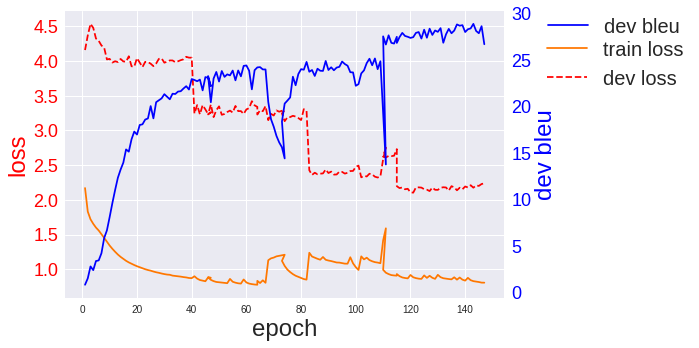

In [9]:
fig, ax1 = plt.subplots()
fig.set_size_inches(8,5)
ax1.plot(log_train[0], log_train[1], color='#ff7700')
ax1.plot(log_test[0], log_test[1], 'r--')
ax1.set_xlabel('epoch', size=24)
ax1.set_ylabel('loss', color='r', size=24)
for tl in ax1.get_yticklabels():
    tl.set_color('r')
    tl.set_fontsize(18)
plt.legend(['train loss', 'dev loss'], bbox_to_anchor=(1.45, 0.96), framealpha=0, fontsize=20)    
ax2 = ax1.twinx()
ax2.plot(log_test[0], log_test[2]*100, 'b-')
ax2.set_xlabel('iteration')
ax2.set_ylabel('dev bleu', color='b', size=24)
# ax1.set_xlim(0, 60)
for tl in ax2.get_yticklabels():
    tl.set_color('b')
    tl.set_fontsize(18) 
plt.legend(['dev bleu'], bbox_to_anchor=(1.44, 1.04), framealpha=0, fontsize=20)
# plt.legend(['dev bleu'], bbox_to_anchor=(1.06, 0.9), framealpha=0, fontsize=20)
plt.grid(False)
plt.tight_layout()

In [10]:
import nltk.translate.bleu_score

In [11]:
def play_utt(utt, m_dict):
    sr, y = scipy.io.wavfile.read(os.path.join(wavs_path, utt.rsplit("-",1)[0]+'.wav'))
    start_t = min(seg['start'] for seg in m_dict[utt]['seg'])
    end_t = max(seg['end'] for seg in m_dict[utt]['seg'])
    print(start_t, end_t)
    start_t_samples, end_t_samples = int(start_t*sr), int(end_t*sr)
    display(Audio(y[start_t_samples:end_t_samples], rate=sr))

In [12]:
def display_words(m_dict, v_dict, preds, utts, dec_key, key, min_len=0, max_len=MAX_EN_LEN):
    es_ref = []
    en_ref = []
    for u in utts:
        es_ref.append(" ".join([w.decode() for w in m_dict[u]['es_w']]))
        if type(m_dict[u][dec_key]) == list:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
        else:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w'][0]]))

    en_pred = []
    join_str = ' ' if dec_key.endswith('_w') else ''

    for p in preds:
        t_str = join_str.join([v_dict['i2w'][i].decode() for i in p])
        t_str = t_str[:t_str.find('_EOS')]
        en_pred.append(t_str)

    for u, es, en, p in zip(utts, es_ref, en_ref, en_pred):
        if len(en.split(" ")) >= min_len and len(en.split(" ")) <= max_len:
            # for reference, 1st word is GO_ID, no need to display
            print("Utterance: {0:s}".format(u))
            display_pp = PrettyTable(["cat","sent"], hrules=True)
            display_pp.align = "l"
            display_pp.header = False
            display_pp.add_row(["es ref", textwrap.fill(es,50)])
            display_pp.add_row(["en ref", textwrap.fill(en,50)])
            display_pp.add_row(["en pred", textwrap.fill(p,50)])

            print(display_pp)
            play_utt(u, m_dict)
    

In [13]:
def display_words_latex(m_dict, v_dict, preds, utts, dec_key, min_len=0, max_len=2*MAX_EN_LEN):
    print("min length={0:d}, max length={1:d}".format(min_len, max_len))
    es_ref = []
    en_ref = []
    for u in utts:
        es_ref.append(" ".join([w.decode() for w in m_dict[u]['es_w']]))
        if type(m_dict[u][dec_key]) == list:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
        else:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w'][0]]))

    en_pred = []
    join_str = ' ' if dec_key.endswith('_w') else ''

    for p in preds:
        t_str = join_str.join([v_dict['i2w'][i].decode() for i in p])
        t_str = t_str[:t_str.find('_EOS')]
        en_pred.append(t_str)

    total_matching_len = 0

    for u, es, en, p in zip(utts, es_ref, en_ref, en_pred):
        if len(es.split(" ")) >= min_len and len(es.split(" ")) <= max_len:
            total_matching_len += 1
            # for reference, 1st word is GO_ID, no need to display
            print("Utterance: {0:s}".format(u))
            print("{0:d} & {1:s} & {2:s} & {3:s} \\\\".format(total_matching_len, es, en, p))

    print("total utts matching length filters={0:d}".format(total_matching_len))

### Fisher dev

In [14]:
key='fisher_dev'
train=False
m_dict = map_dict[key]
v_dict = vocab_dict[dec_key]
n=len(map_dict[key])
BATCH_SIZE = 100

In [15]:
cat_speech_path = os.path.join(out_path, key)
wavs_path = os.path.join(out_path, "wavs")

In [16]:
print("-"*80)
print("EPOCH = {0:d}".format(last_epoch+1))
fsh_pred_sents, fsh_utts, loss = feed_model(map_dict[key],
                  b_dict=bucket_dict[key],
                  vocab_dict=vocab_dict,
                  batch_size=BATCH_SIZE,
                  x_key=enc_key,
                  y_key=dec_key,
                  train=train,
                  cat_speech_path=cat_speech_path, use_y=True)

print("{0:s} {1:s} mean loss={2:.4f}".format("*" * 10,
                                    "train" if train else "dev",
                                    loss))
print("-")
print("-"*80)

  0%|                                                  | 0/3977 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
EPOCH = 146


b=5,l=3.61,avg=2.17: 100%|██████████████████| 3977/3977 [02:20<00:00,  9.08it/s]

********** dev mean loss=2.1732
-
--------------------------------------------------------------------------------


In [17]:
# Eval parameters
ref_index = 0
min_len, max_len= 0, 200

In [18]:
# display_words(m_dict, v_dict, fsh_pred_sents, fsh_utts, dec_key, key, min_len=min_len, max_len=max_len)

In [19]:
# display_words_latex(m_dict, v_dict, fsh_pred_sents, fsh_utts, dec_key, min_len=min_len, max_len=max_len)

In [20]:
# def calc_bleu(m_dict, 
#               v_dict, 
#               preds, 
#               utts, 
#               dec_key, 
#               weights=(0.25, 0.25, 0.25, 0.25), 
#               min_len=0, 
#               max_len=2*MAX_EN_LEN, 
#               ref_index=0):
#     print("min length={0:d}, max length={1:d}".format(min_len, max_len))
#     en_hyp = []
#     en_ref = []
#     ref_key = 'en_w' if 'en_' in dec_key else 'es_w'
#     src_key = 'es_w'
#     for u in tqdm(utts, ncols=80):
#         if len(m_dict[u][src_key]) >= min_len and len(m_dict[u][src_key]) <= max_len:
#             if type(m_dict[u][ref_key]) == list:
#                 en_ref.append([w.decode() for w in m_dict[u][ref_key]])
#             else:
#                 en_r_list = []
#                 for r in m_dict[u][ref_key]:
#                     en_r_list.append([w.decode() for w in r])
#                 en_ref.append(en_r_list)

#     join_str = ' ' if dec_key.endswith('_w') else ''

#     total_matching_len = 0

#     for u, p in zip(utts, preds):
#         if len(m_dict[u][src_key]) >= min_len and len(m_dict[u][src_key]) <= max_len:
#             total_matching_len += 1
#             t_str = join_str.join([v_dict['i2w'][i].decode() for i in p])
#             t_str = t_str[:t_str.find('_EOS')]
#             en_hyp.append(t_str.split())


#     print("total utts matching length filters={0:d}".format(total_matching_len))

#     smooth_fun = nltk.translate.bleu_score.SmoothingFunction()

#     b_score_value = corpus_bleu(en_ref,
#                           en_hyp,
#                           weights=weights,
#                           smoothing_function=smooth_fun.method2)

#     chrf_score_value = corpus_chrf([r[ref_index] for r in en_ref], en_hyp)

#     return b_score_value, chrf_score_value, en_hyp, en_ref

In [21]:
b, _, h, r = calc_bleu(m_dict, 
                              v_dict, 
                              fsh_pred_sents[:n], 
                              fsh_utts[:n], 
                              dec_key, 
                              min_len=min_len, 
                              max_len=max_len, 
                              ref_index=ref_index)

print("BLEU score on: {0:s} = {1:.2f}".format(key, b * 100))
print("-"*60)

chrf = [0]*4

for ref_i in range(4):
    _, chrf[ref_i], _, _ = calc_bleu(m_dict, 
                              v_dict, 
                              fsh_pred_sents[:n], 
                              fsh_utts[:n], 
                              dec_key, 
                              min_len=min_len, 
                              max_len=max_len, 
                              ref_index=ref_i)
    # end for

# print chrf score
for i in range(4):
    print("CHRF score on: {0:s} = {1:.2f}, using reference = {2:d}".format(key, chrf[i] * 100, i))

print("-"*60)

all_weights=[(1.,0.,0.,0.),
             (0.,1.,0.,0.),
             (0.,0.,1.,0.),
             (0.,0.,0.,1.),
             (1./2,1./2,0.,0.),
             (1./3,1./3,1./3,0.),
             (.25,.25,.25,.25)]

  0%|                                                  | 0/3977 [00:00<?, ?it/s]

min length=0, max length=200


100%|████████████████████████████████████| 3977/3977 [00:00<00:00, 61083.74it/s]

total utts matching length filters=3977
BLEU score on: fisher_dev = 27.82
------------------------------------------------------------
min length=0, max length=200



100%|████████████████████████████████████| 3977/3977 [00:00<00:00, 61560.98it/s]

total utts matching length filters=3977
min length=0, max length=200



100%|████████████████████████████████████| 3977/3977 [00:00<00:00, 63132.04it/s]

total utts matching length filters=3977
min length=0, max length=200



100%|████████████████████████████████████| 3977/3977 [00:00<00:00, 63677.18it/s]

total utts matching length filters=3977
min length=0, max length=200
total utts matching length filters=3977
CHRF score on: fisher_dev = 56.81, using reference = 0
CHRF score on: fisher_dev = 49.51, using reference = 1
CHRF score on: fisher_dev = 49.60, using reference = 2
CHRF score on: fisher_dev = 69.25, using reference = 3
------------------------------------------------------------


In [ ]:
smooth_fun = nltk.translate.bleu_score.SmoothingFunction()

In [ ]:
print("{0:>20s} | {1:20s}".format("bleu score (0-100)", "uni-bi-tri-quad"))
for weights in all_weights:
    b = corpus_bleu(r, h, weights=weights, smoothing_function=smooth_fun.method3)
    print("{0:20.2f} | {1:20s}".format(b * 100, "-".join(map("{0:.2f}".format, weights))))

In [ ]:
_, _ = corpus_precision_recall(r, h)

In [ ]:
pred_path = "/afs/inf.ed.ac.uk/group/project/lowres/work/installs/fisher-callhome-corpus/corpus/ldc"
pred_fname = os.path.join(pred_path, "fisher_dev.pred")

In [ ]:
len(m_dict[fsh_utts[0]]['en_w'])

In [ ]:
def write_predictions_to_file(m_dict, v_dict, preds, utts, dec_key, key, min_len=0, max_len=2*MAX_EN_LEN):
    print("min length={0:d}, max length={1:d}".format(min_len, max_len))
    en_hyp = []
    en_ref = []
    ref_key = 'en_w' if 'en_' in dec_key else 'es_w'
    src_key = 'es_w'
    
    for u in tqdm(utts, ncols=80):
        if len(m_dict[u][src_key]) >= min_len and len(m_dict[u][src_key]) <= max_len:
            if type(m_dict[u][ref_key]) == list:
                en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
            else:
                en_r_list = []
                for r in m_dict[u][ref_key]:
                    en_r_list.append(" ".join([w.decode() for w in r]))
                en_ref.append(en_r_list)

    join_str = ' ' if dec_key.endswith('_w') else ''

    total_matching_len = 0

    for u, p in zip(utts, preds):
        if len(m_dict[u][src_key]) >= min_len and len(m_dict[u][src_key]) <= max_len:
            total_matching_len += 1
            t_str = join_str.join([v_dict['i2w'][i].decode() for i in p])
            t_str = t_str[:t_str.find('_EOS')]
            en_hyp.append(t_str)


    print("total utts matching length filters={0:d}".format(total_matching_len))
    
    with open("{0:s}_mt-output".format(key), "w") as pred_f:
        for p in en_hyp:
            pred_f.write("{0:s}\n".format(p))
        # end for
    # end while
    
    
    if type(m_dict[utts[0]][ref_key]) == list:
        with open("{0:s}.ref0".format(key), "w") as ref_f:
            for r in en_ref:
                ref_f.write("{0:s}\n".format(r))
    else:
        num_ref = len(m_dict[u][ref_key])
        for i in range(num_ref):
            with open("{0:s}_en.ref{1:d}".format(key,i), "w") as ref_f:
                for r in en_ref:
                    ref_f.write("{0:s}\n".format(r[i]))
                # end for each utt
            # end with
        # end for reference
    # end else
    print("done")
    return en_ref, en_hyp

In [ ]:
en_ref, en_hyp = write_predictions_to_file(m_dict, v_dict, fsh_pred_sents, fsh_utts, dec_key, key, min_len=min_len, max_len=max_len)

In [ ]:
len(en_ref),len(en_hyp)

### Callhome dev

In [ ]:
key='callhome_devtest'
train=False
m_dict = map_dict[key]
v_dict = vocab_dict[dec_key]
n=len(map_dict[key])
BATCH_SIZE = 100

In [ ]:
cat_speech_path = os.path.join(out_path, key)

In [ ]:
print("-"*80)
print("EPOCH = {0:d}".format(last_epoch+1))
pred_sents, utts, loss = feed_model(map_dict[key],
                  b_dict=bucket_dict[key],
                  vocab_dict=vocab_dict,
                  batch_size=BATCH_SIZE,
                  x_key=enc_key,
                  y_key=dec_key,
                  train=train,
                  cat_speech_path=cat_speech_path, use_y=True)

print("{0:s} {1:s} mean loss={2:.4f}".format("*" * 10,
                                    "train" if train else "dev",
                                    loss))
print("-")
print("-"*80)

In [ ]:
display_words(m_dict, v_dict, pred_sents[:50], utts[:50], dec_key)

In [ ]:
b, h, r = calc_bleu(m_dict, v_dict, pred_sents[:n], utts[:n], dec_key)

print("BLEU score on: {0:s} = {1:.2f}".format(key, b * 100))

print("-"*60)

all_weights=[(1.,0.,0.,0.),
             (0.,1.,0.,0.),
             (0.,0.,1.,0.),
             (0.,0.,0.,1.),
             (1./2,1./2,0.,0.),
             (1./3,1./3,1./3,0.),
             (.25,.25,.25,.25)]

In [ ]:
smooth_fun = nltk.translate.bleu_score.SmoothingFunction()

In [ ]:
print("{0:>20s} | {1:20s}".format("bleu score (0-100)", "uni-bi-tri-quad"))
for weights in all_weights:
    b = corpus_bleu(r, h, weights=weights, smoothing_function=smooth_fun.method2)
    print("{0:20.2f} | {1:20s}".format(b * 100, "-".join(map("{0:.2f}".format, weights))))

In [ ]:
_, _ = corpus_precision_recall(r, h)

### Test code

In [ ]:
# test_ref = [["ha ha lol hue".split()], ["ha ha ja ha".split()], ["ha ha ja ha".split()]]
# test_h = ["lol ja".split(), "ha he".split(), "ha ja".split()]
# _, _ = corpus_precision_recall(test_ref, test_h)